## ISIC 2018: Skin Lesion Analysis Towards Melanoma Detection Challenge
This is divided into 3 parts:
1. Lesion Boundary Segmentation
2. Lesion Attribute Detection
3. Disease Classification

### Abstract

Melanoma is a type of skin cancer that develops when melanocytes (the cells that give the skin its tan or brown color) start to grow out of control.

Cancer starts when cells in the body begin to grow out of control. Cells in nearly any part of the body can become cancer, and can then spread to other areas of the body

Melanoma is much less common than some other types of skin cancers. But melanoma is more dangerous because it’s much more likely to spread to other parts of the body if not caught and treated early


In this notebook, I will be performing task1 of ISIC challenge -- Lesion Boundary Segmentation using Unet



### Acknowledgements

The website hosting the data is located at https://challenge2018.isic-archive.com/task1/. The lesion images were acquired with a variety of dermatoscope types, from all anatomic sites (excluding mucosa and nails), from a historical sample of patients presented for skin cancer screening, from several different institutions. Every lesion image contains exactly one primary lesion; other fiducial markers, smaller secondary lesions

### Project Aim:

To participate in this task:

Train
Download the training input data and training ground truth response data.
Develop an algorithm for generating lesion segmentations in general.

Validate 
Download the validation input data.
Run your algorithm on the validation Input data to produce validation predicted responses.

## PART1 : Lesion Boundary Segmentation

### Information about data

Training images -- The training data consists of 2594 images and 2594 corresponding ground truth response masks.


Input Dataset   

The input data are dermoscopic 2594 lesion images in JPEG format.

Every lesion image contains exactly one primary lesion; other fiducial markers, smaller secondary lesions, or other pigmented regions may be neglected.

Masks 

Mask images are encoded as single-channel (grayscale) 8-bit PNGs, where each pixel is either:

0: representing the background of the image, or areas outside the primary lesion

255: representing the foreground of the image, or areas inside the primary lesion

so num_classes = 2 

Getting started with importing Libraries

In [1]:
#-----IMPORTS----- 
import os
import random
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
import random
from PIL import ImageOps
import tensorflow.keras.layers as layers

Creating directories to access files from local system

In [3]:
# ----creating directories----
input_dir = ("/Users/rishikarishika/Final_project_GAns/ISIC2018_Task1-2_Training_Input") #contains the input images
test_dir = ("/Users/rishikarishika/Final_project_GAns/ISIC2018_Task1-2_Test_Input/")
target_dir = ("/Users/rishikarishika/Final_project_GAns/ISIC2018_Task1_Training_GroundTruth/") #contains the target masks

## Prepare paths for input images and target segmentation masks

Setting all image sizes to (160,160), the number of target classes is 2 as either the pixel will be 0 or 255 (semantic) and batch_size is set to 32 as this is known to give great results in image segmentations

Input_images are in .jpg format, hence the endswith (.jpg) conditon

Target_images are in .png format, hence the endswith (.png) conditon

In [4]:
img_size = (160,160)  
num_classes = 2 #either 0 or 250
batch_size = 32 


input_img_paths = sorted(
[
    os.path.join(input_dir, fname)    #joining the directory contents with the filename to read the contents 
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg") #training dataset --  lesion images is in jpg format --- 
])

target_img_paths = sorted(
[
    os.path.join(target_dir, fname)    
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".") # masks -- images are in png format
]
)

print("Number of samples: ", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples:  2594
/Users/rishikarishika/Final_project_GAns/ISIC2018_Task1-2_Training_Input/ISIC_0000000.jpg | /Users/rishikarishika/Final_project_GAns/ISIC2018_Task1_Training_GroundTruth/ISIC_0000000_segmentation.png
/Users/rishikarishika/Final_project_GAns/ISIC2018_Task1-2_Training_Input/ISIC_0000001.jpg | /Users/rishikarishika/Final_project_GAns/ISIC2018_Task1_Training_GroundTruth/ISIC_0000001_segmentation.png
/Users/rishikarishika/Final_project_GAns/ISIC2018_Task1-2_Training_Input/ISIC_0000003.jpg | /Users/rishikarishika/Final_project_GAns/ISIC2018_Task1_Training_GroundTruth/ISIC_0000003_segmentation.png
/Users/rishikarishika/Final_project_GAns/ISIC2018_Task1-2_Training_Input/ISIC_0000004.jpg | /Users/rishikarishika/Final_project_GAns/ISIC2018_Task1_Training_GroundTruth/ISIC_0000004_segmentation.png
/Users/rishikarishika/Final_project_GAns/ISIC2018_Task1-2_Training_Input/ISIC_0000006.jpg | /Users/rishikarishika/Final_project_GAns/ISIC2018_Task1_Training_GroundTruth/ISIC_00000

Now that we have successfully imported the datasets, our goal is to perform image segmentation on each of the training images.


Image Segmentation : Its defined as a process of classifying each pixel in the image belonging to a specific category

Types of Image Segmentation :

1. Semantic Segmentation : every pixel of an object belonging to a particular class is given the same color/value
2. Instance Segmentation : every pixel of an object belonging to a particular class is given seperate color/value


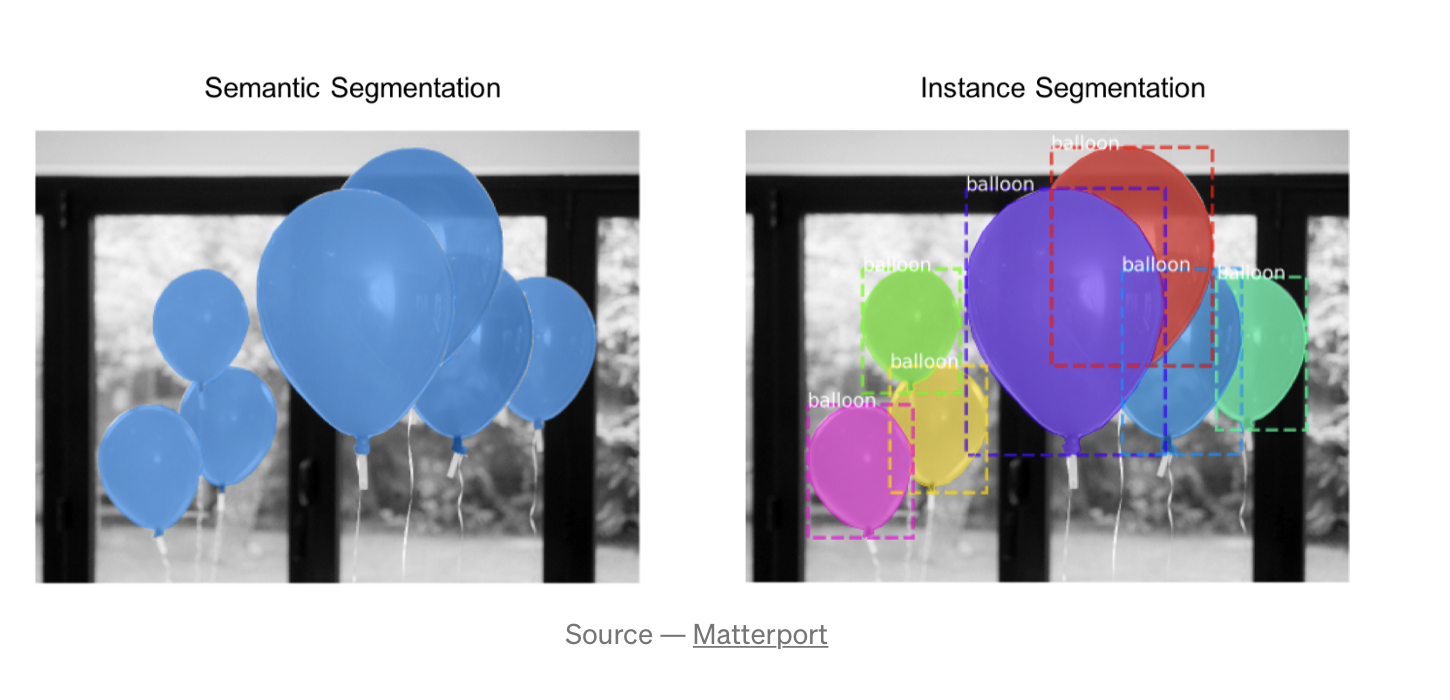


So, in Task-1 ,Since we are just trying to predict lesion segmentation from the dermoscopic images, we can use semantic segmentation  

## what does one input image and corresponding segmentation mask look like?

### Understanding the data better

In the images directory, there are lesion images which are used by human experts to predict whether there could be melanoma or not.
In the masks directory, there are gray scale images which are the actual ground truth values of the corresponding images which denote whether the image contains melanoma and if so where. These will be used for building a supervised learning model.
Let’s visualize the given data to get a better understanding:

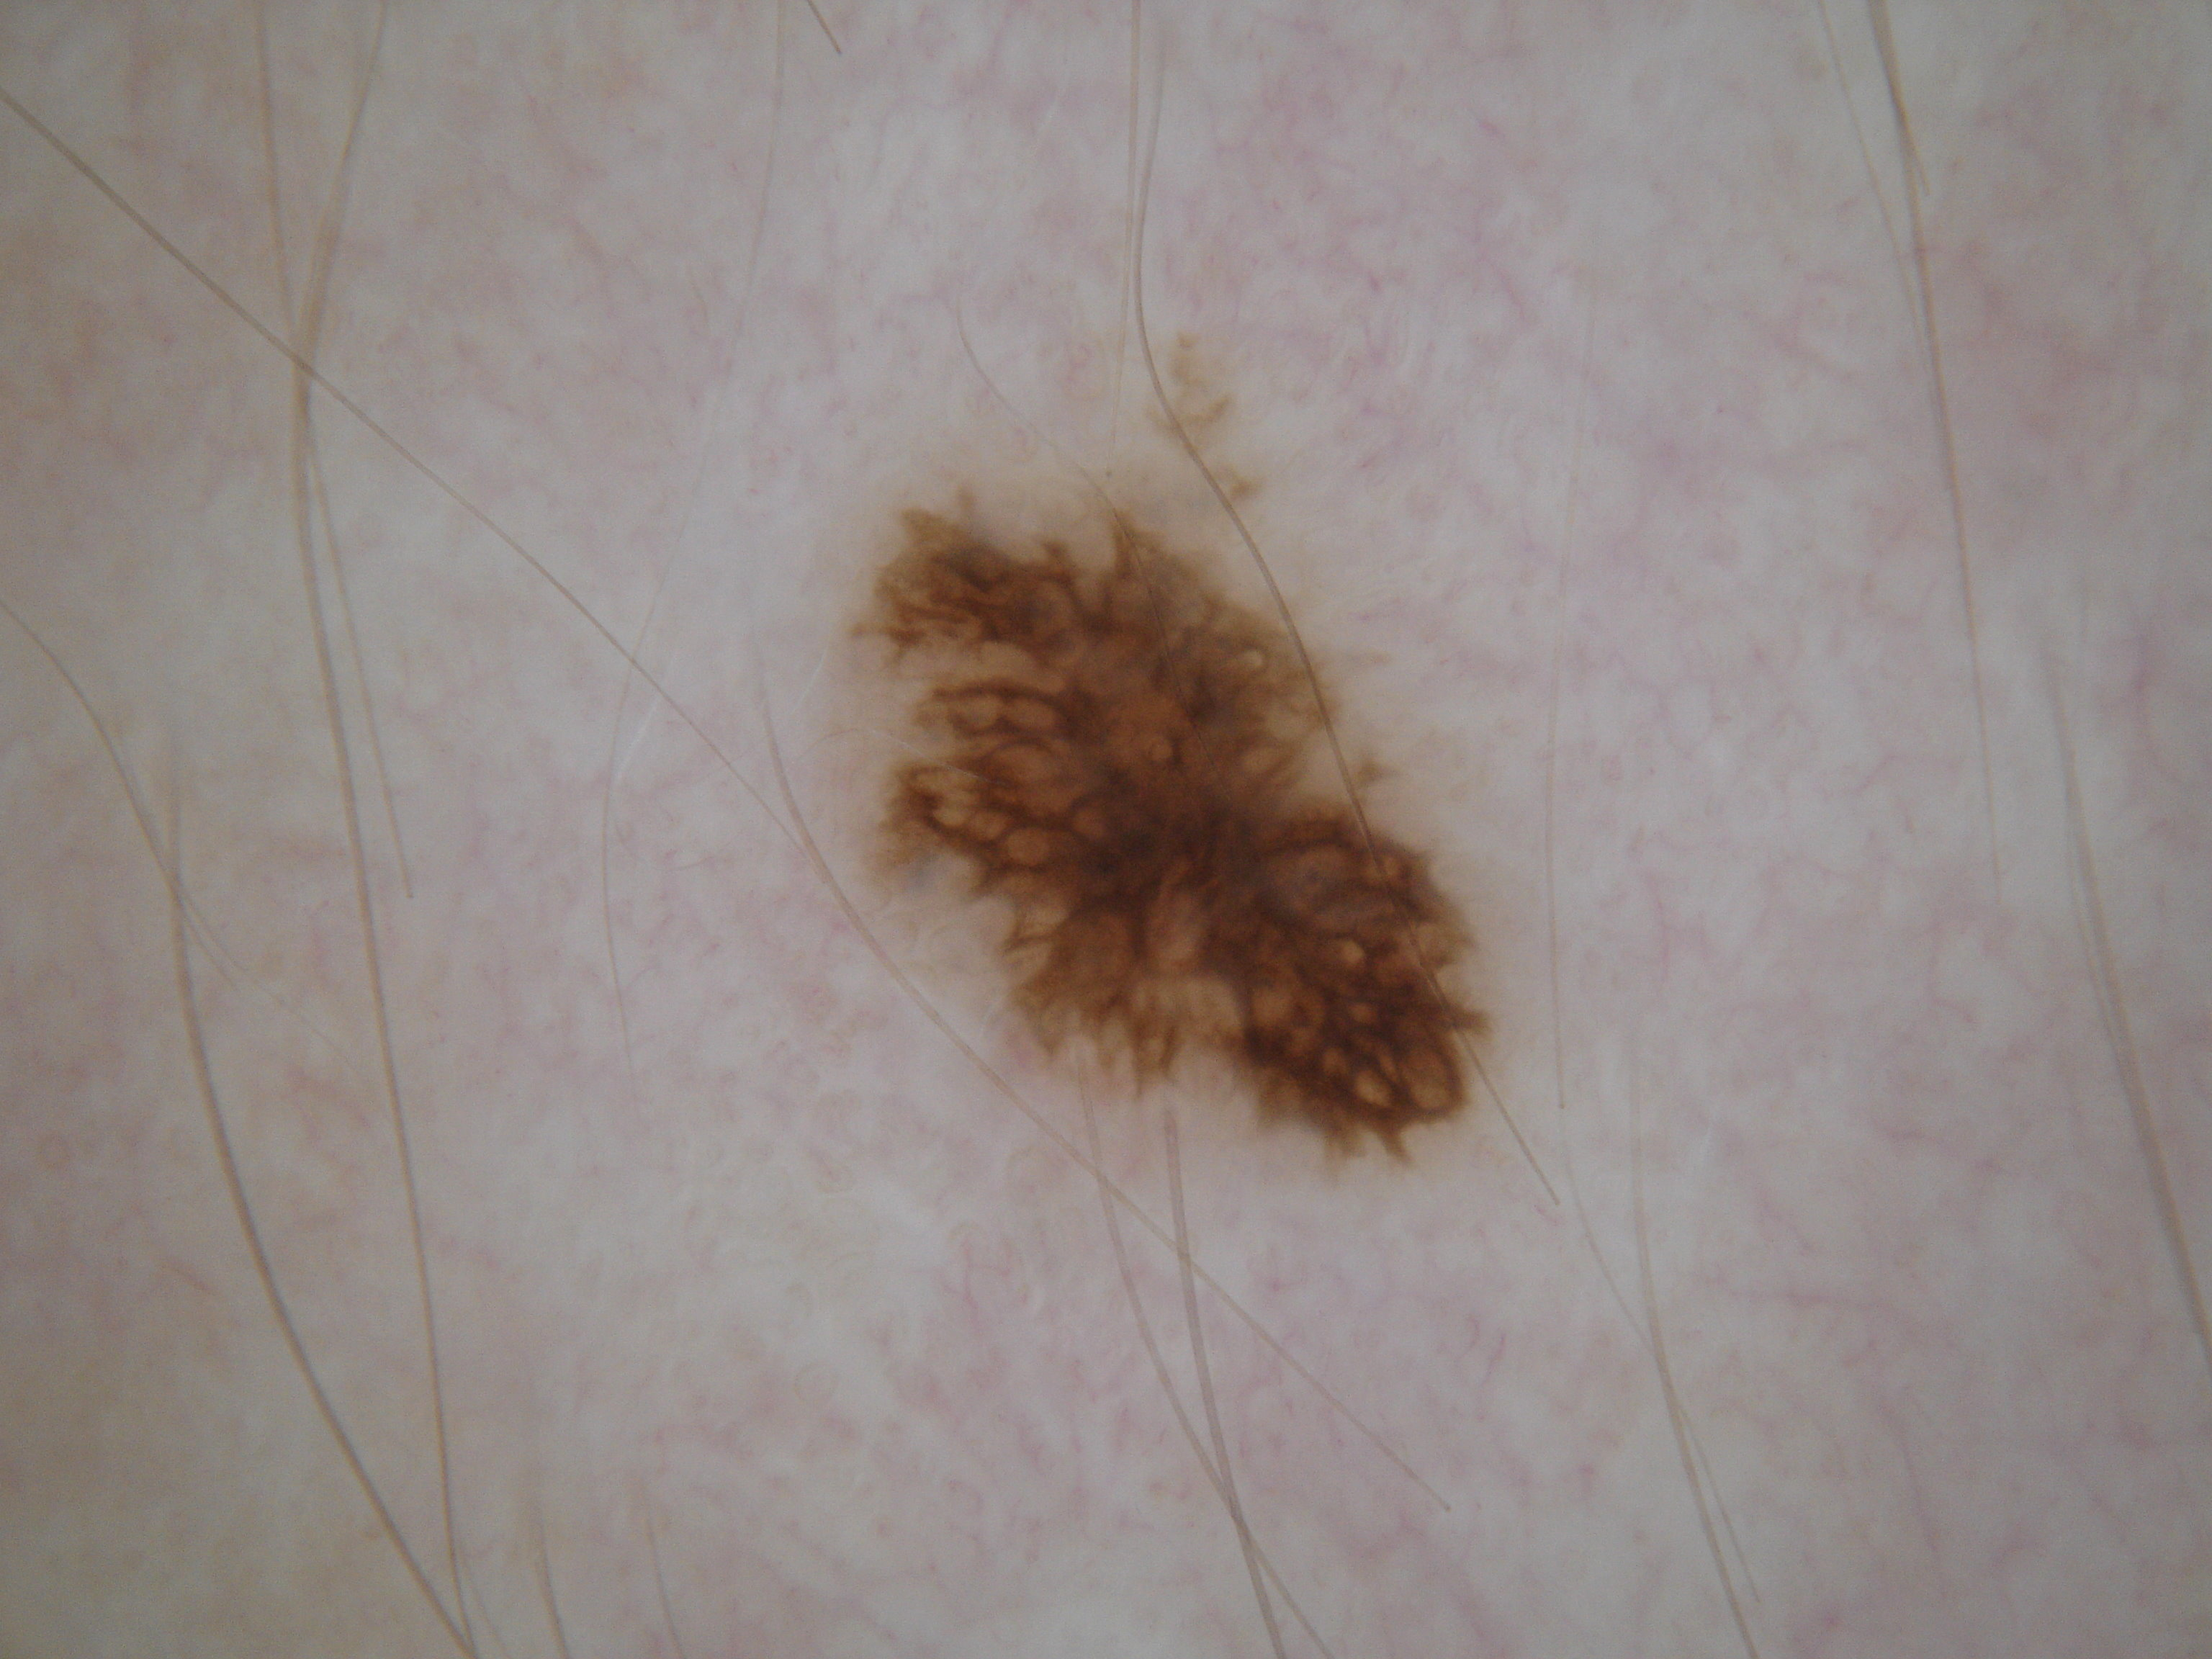

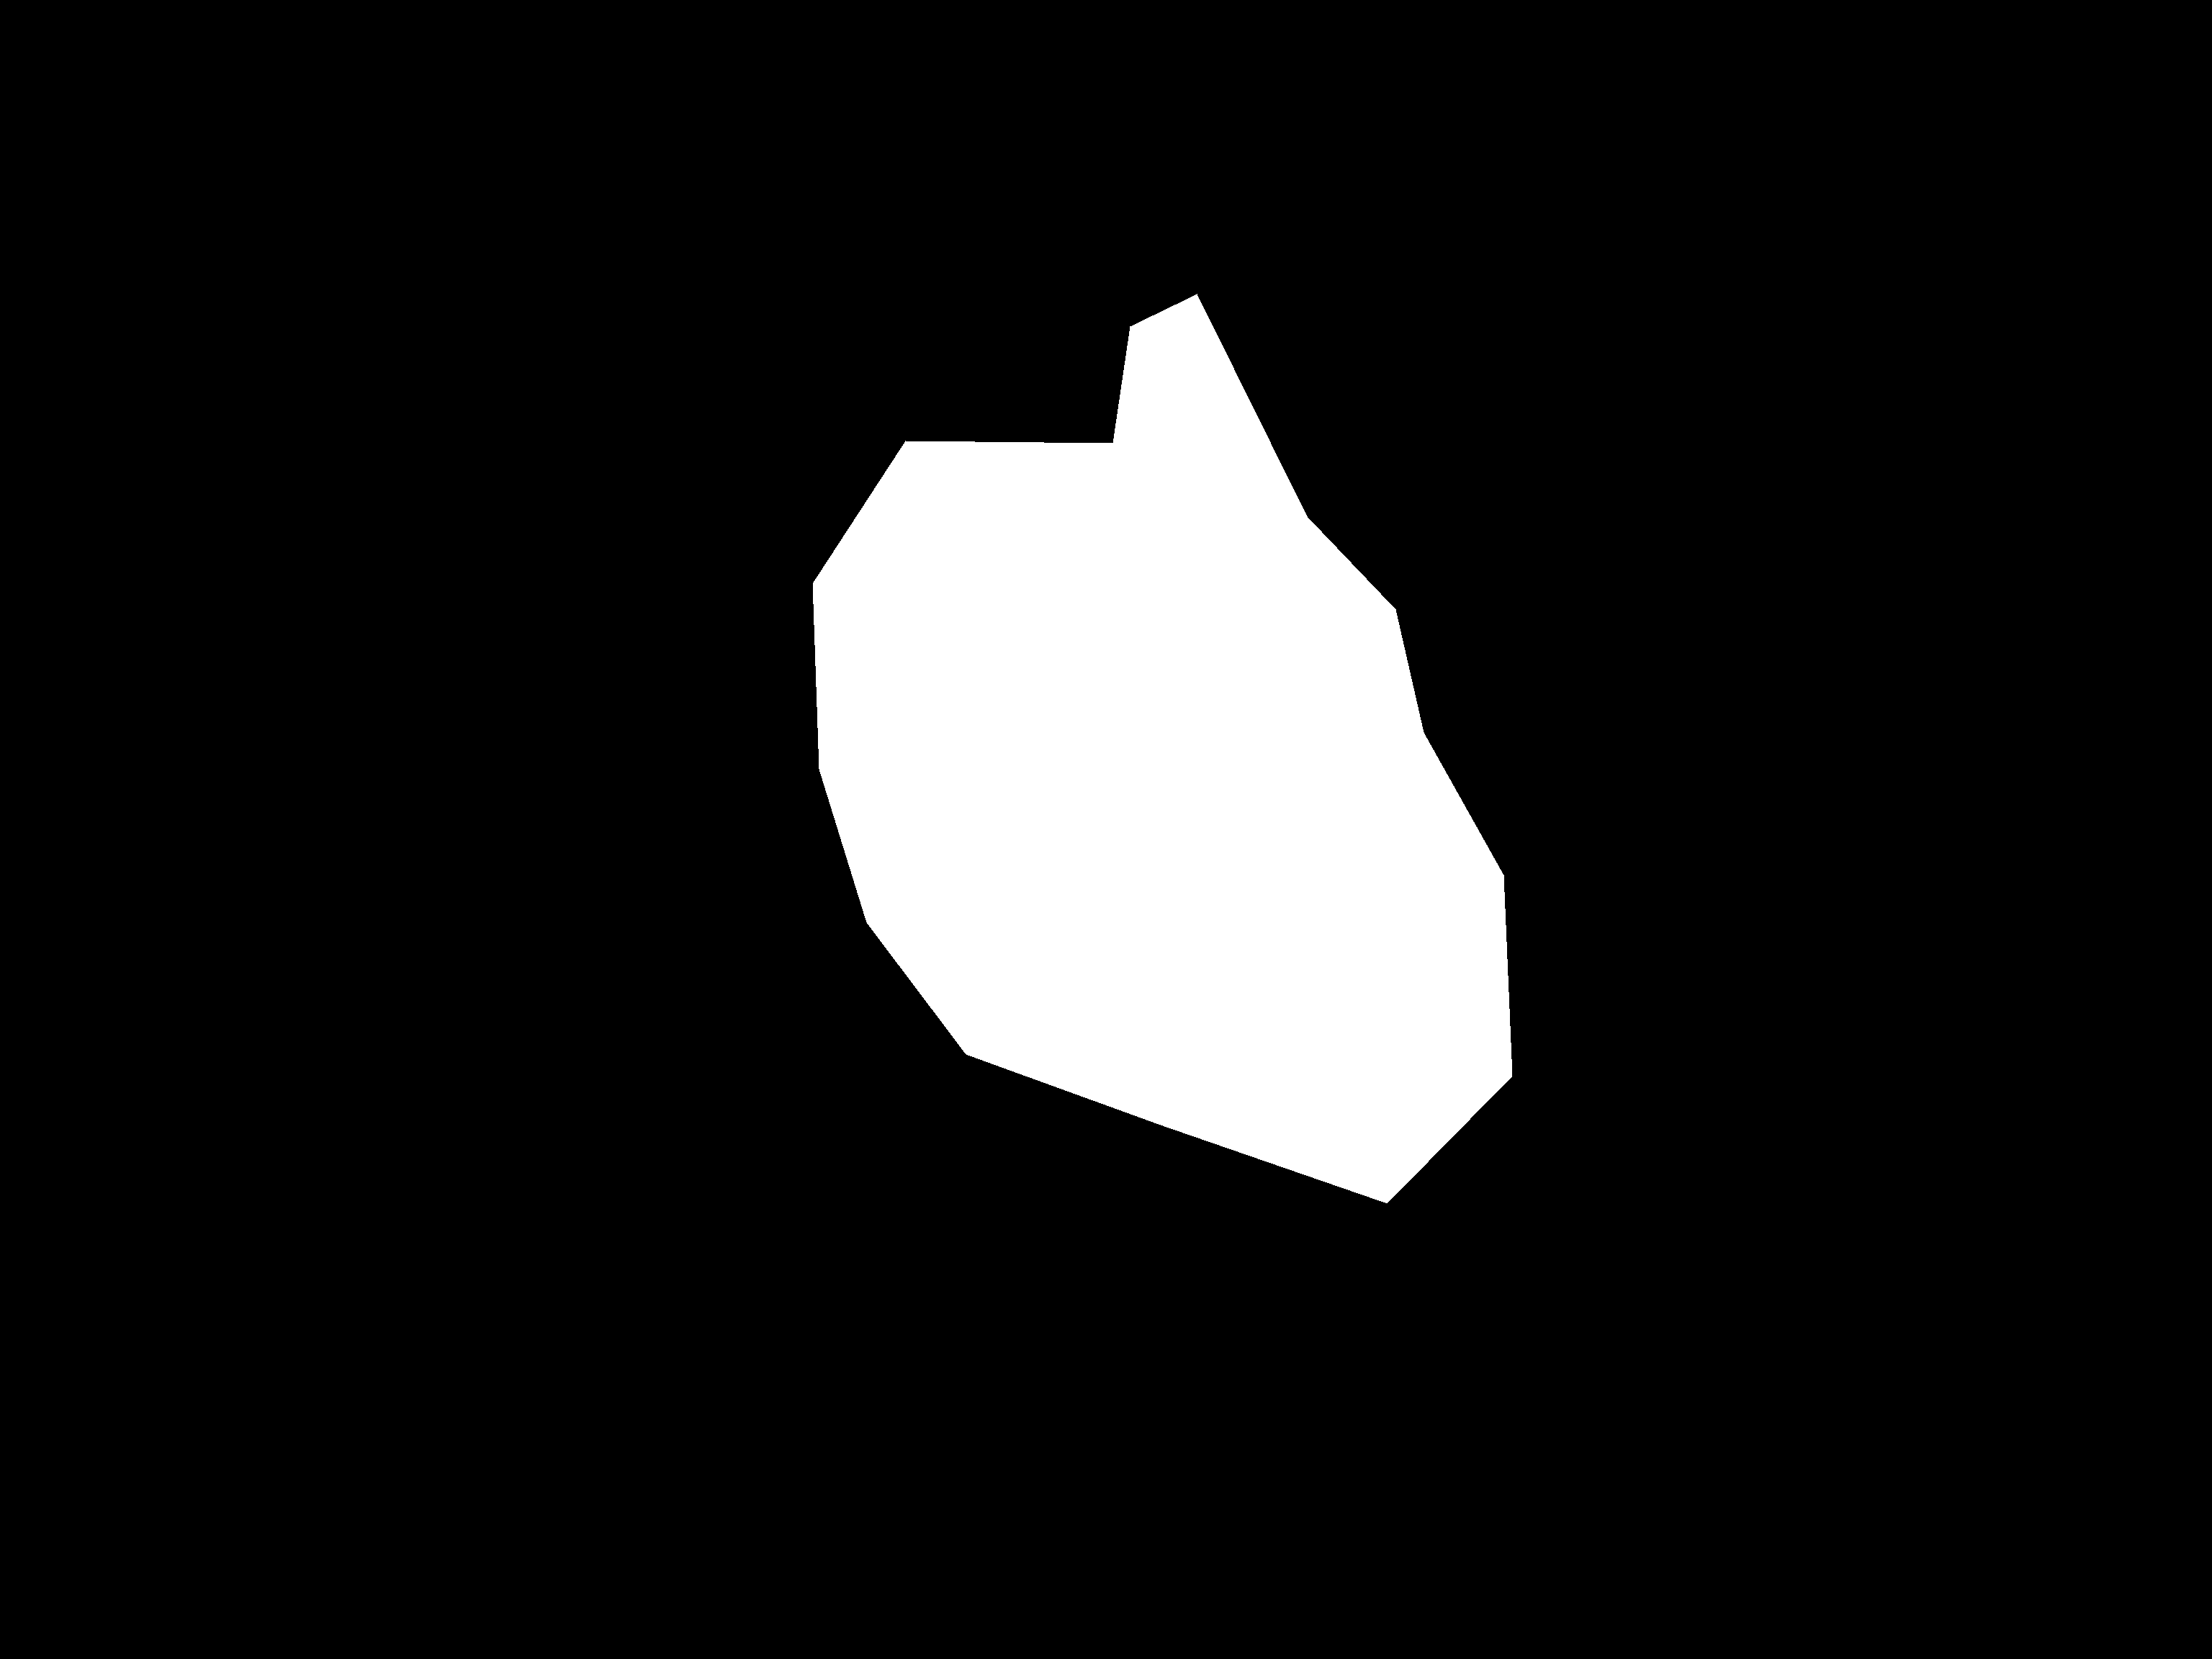

In [5]:
#Display input image #random number
num = random.randint(0, 2594)
display(Image(filename= input_img_paths[num]))

#Display corresponding masks ie target 
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[num]))
display(img)

## Prepare Sequence class to load & vectorize batches of data

Creating a helper class to convert the images into a format which deep learning models can train on ie. arrays

The init function will be the first function that is provoked every time an instance of the class is created

The len function will simply return the length of a batch

The get item function will return a tuple of lesion_images and their corresponding masks 

In [11]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class MelanomaDetection(keras.utils.Sequence):
    """Helper to iterate over the data (as numpy arrays)"""
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths)// self.batch_size
    
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx"""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size, ) + self.img_size + (3,), dtype = "float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size, ) + self.img_size + (1,), dtype = "uint8")
        for j , path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size = self.img_size, color_mode = "grayscale")
            y[j] = np.resize(img, (160,160,1))
        #Ground truth labels are 0 and 255
        return x,y
        

## Prepare U-Net Xception-style model

The architecture contains two paths. 

First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. 

The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. 

Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size. 

### About the first half of the network 

The left hand side is the contraction path (Encoder) where we apply regular convolutions and max pooling layers.

In the Encoder, the size of the image gradually reduces while the depth gradually increases. 

This basically means the network learns the “WHAT” information in the image, however it has lost the “WHERE” information

In [13]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape= img_size + (3,))
    
    ### [First half of the network : downsampling inputs] ###
    
    
    
    #Entry block
    x = layers.Conv2D(32, 3, strides = 2, padding = "same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x # Set aside residual
    
    #Blocks 1, 2, 3 are identical apart from the feature depth
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding = "same")(x)
        
        #Project residual
        residual = layers.Conv2D(filters, 1, strides = 2, padding= "same")(
            previous_block_activation
        )
        x = layers.add([x, residual]) #Add back residual
        previous_block_activation = x #Set aside next residual
        
    ### [Second half of the network : upsampling inputs] ###
    
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = layers.UpSampling2D(2)(x)
        
        #Project residual 
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual]) #Add back residual
        previous_block_activation = x #Set aside next residual
        
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation= "softmax", padding = "same")(x)
    
    #Define the model
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### About the second half of the network 

The right hand side is the expansion path (Decoder) where we apply transposed convolutions along with regular convolutions

In the decoder, the size of the image gradually increases and the depth gradually decreases

Intuitively, the Decoder recovers the “WHERE” information (precise localization) by gradually applying up-sampling


### Summary of the model

In [ ]:
# Build model
model = get_model(img_size, num_classes)
model.summary()

## Set aside a validation split

Setting aside a validation split to validate our results. 

Creating instance of MelanomaDetection to invoke the class

In [14]:
# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(2500).shuffle(input_img_paths)
random.Random(2500).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = MelanomaDetection(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = MelanomaDetection(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

Now we fit and train the model for 15 epochs, early stopping can also be considered if the loss doesnt improve for continuous 10 epochs unlike our case

In [15]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="binary_crossentropy")

#  callbacks = [
#     keras.callbacks.ModelCheckpoint("malanoma_detection.h5", save_best_only=True)
# 

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Train for 49 steps, validate for 31 steps
Epoch 1/15
49/49 [==============================] - 676s 14s/step - loss: 8.7704 - val_loss: 7.7263
Epoch 2/15
49/49 [==============================] - 801s 16s/step - loss: 4.9204 - val_loss: 1.3380
Epoch 3/15
49/49 [==============================] - 4455s 91s/step - loss: 4.9199 - val_loss: 0.9285
Epoch 4/15
49/49 [==============================] - 683s 14s/step - loss: 4.8686 - val_loss: 0.7197
Epoch 5/15
49/49 [==============================] - 690s 14s/step - loss: 4.8692 - val_loss: 0.7160
Epoch 6/15
49/49 [==============================] - 690s 14s/step - loss: 4.7977 - val_loss: 0.8435
Epoch 7/15
49/49 [==============================] - 687s 14s/step - loss: 4.8075 - val_loss: 1.1994
Epoch 8/15
49/49 [==============================] - 672s 14s/step - loss: 4.8008 - val_loss: 2.9693
Epoch 9/15
49/49 [==============================] - 678s 14s/step - loss: 4.7786 - val_loss: 3.7795
Epoch 10/15
49/49 [==============================] - 694s

## Visualize predictions

Visualising the predictions for checking if the liseon images have been segmented correctly

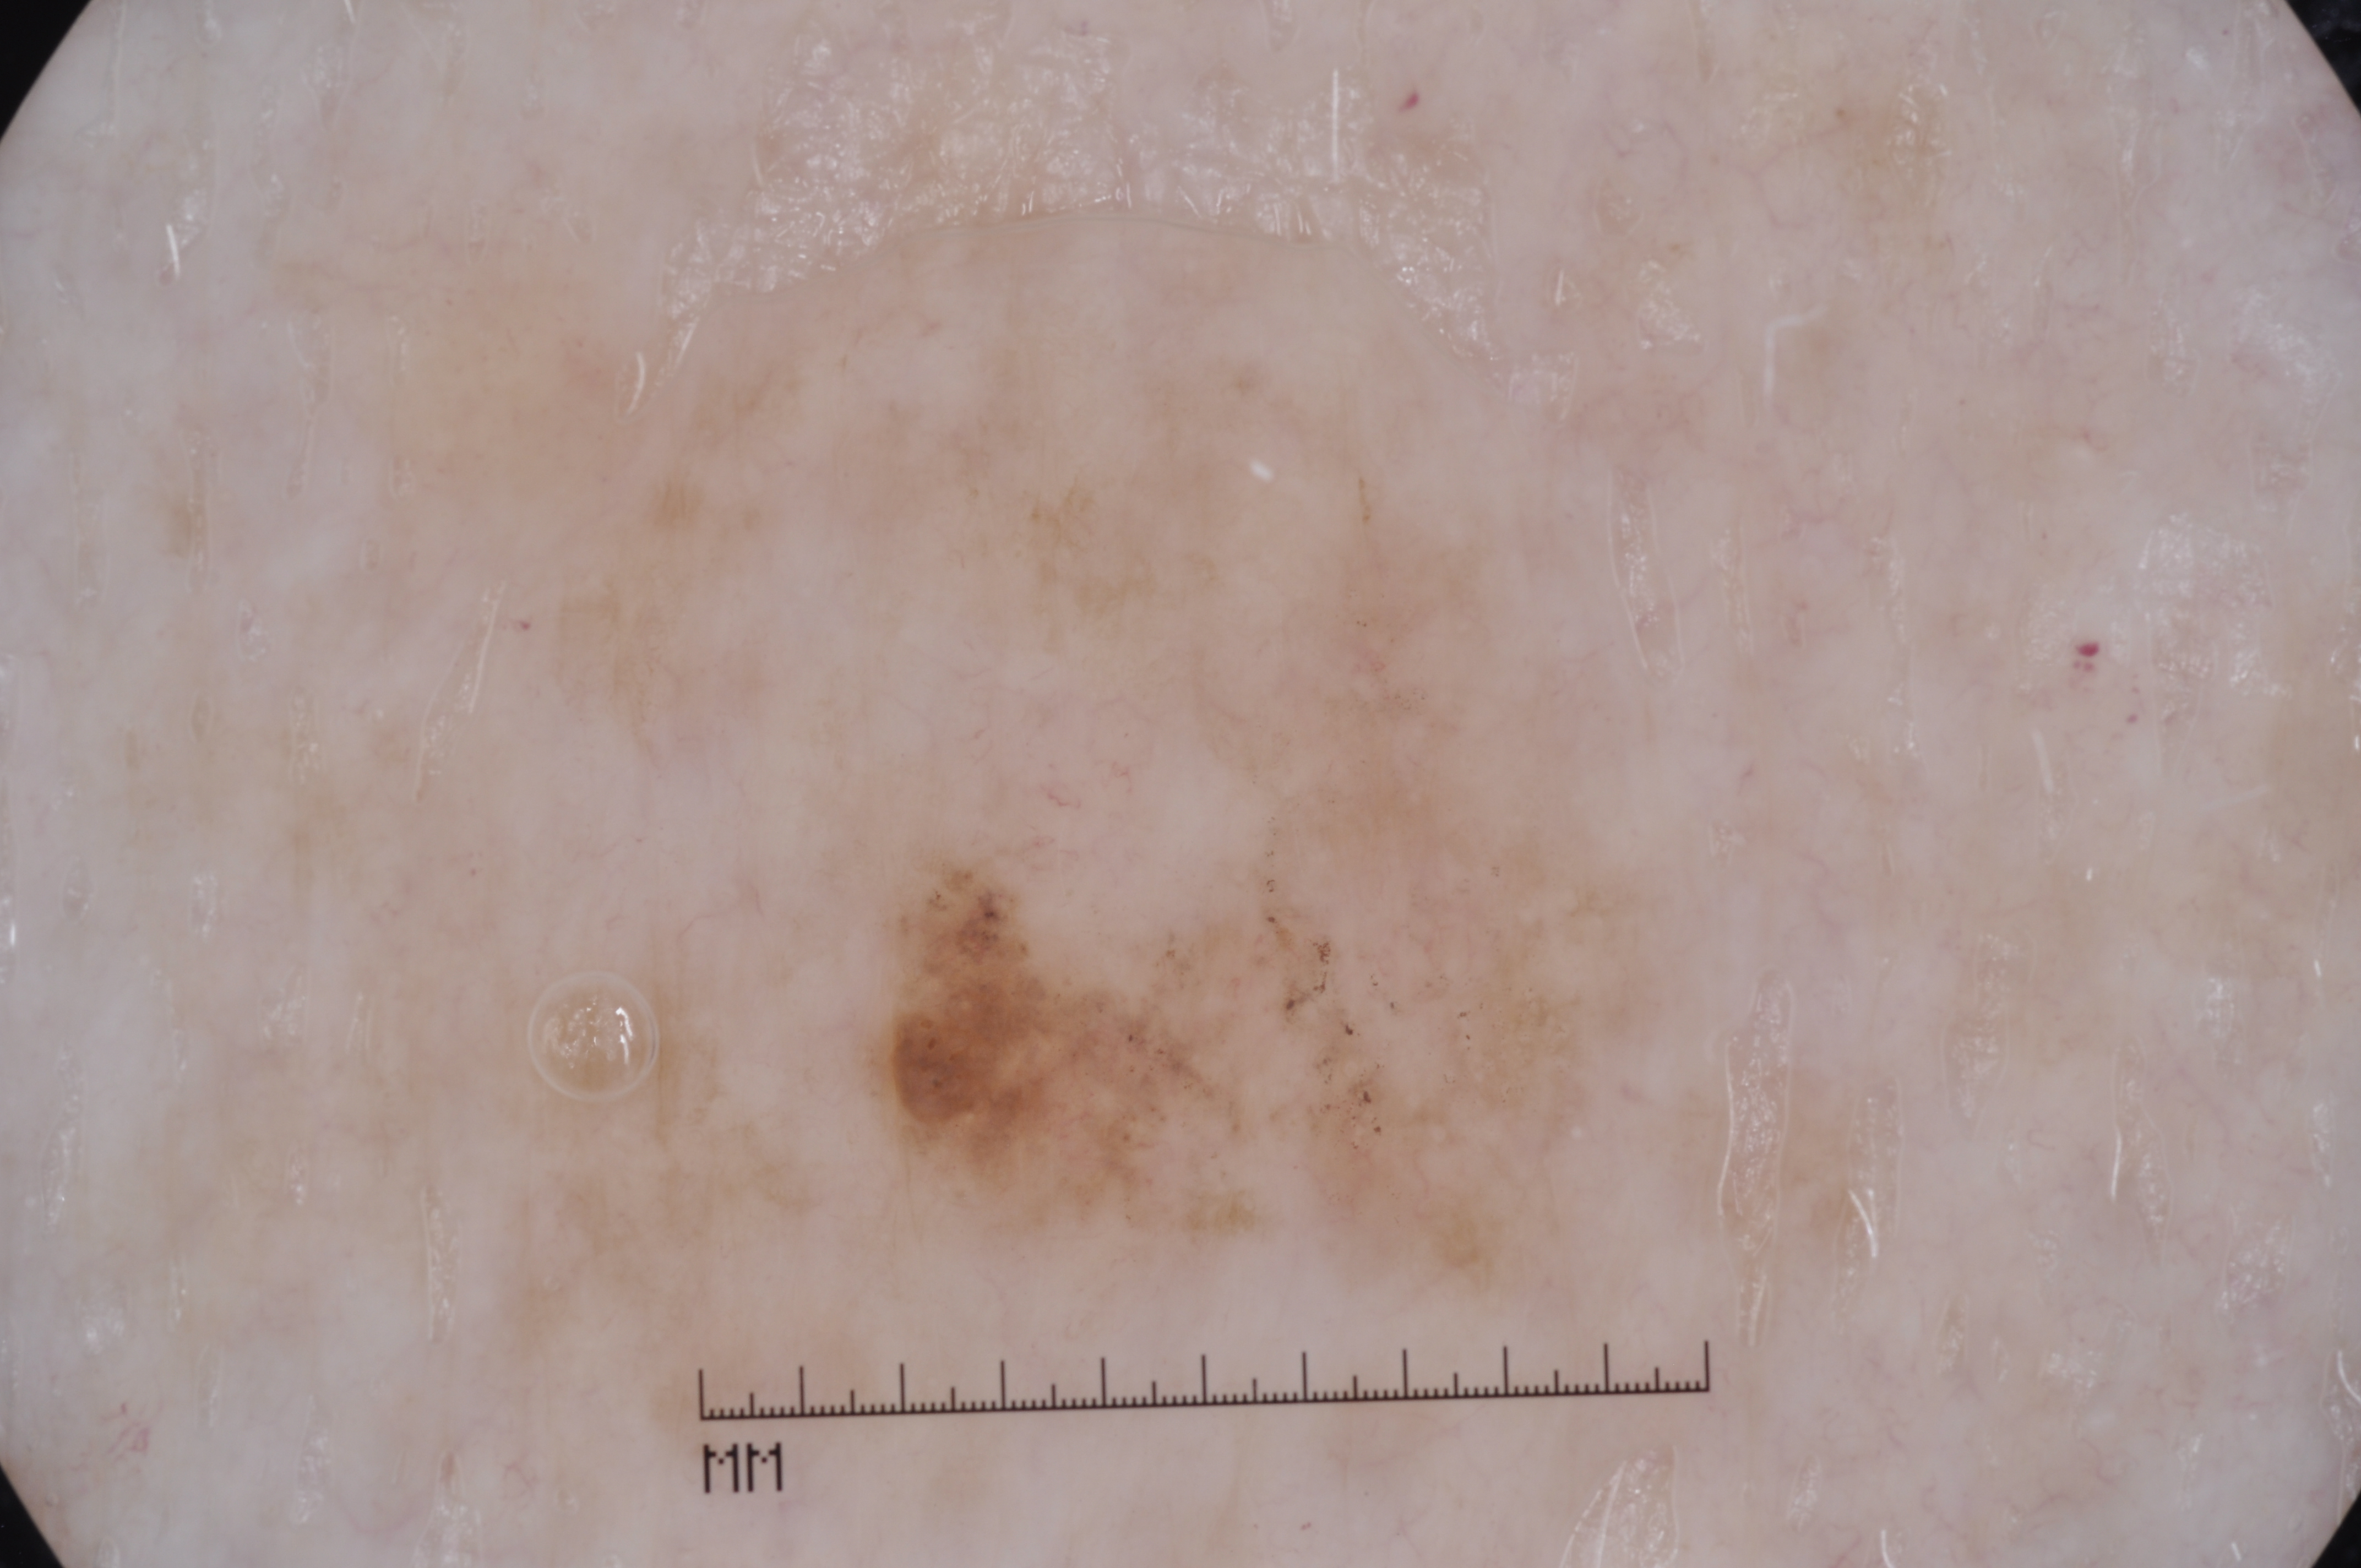

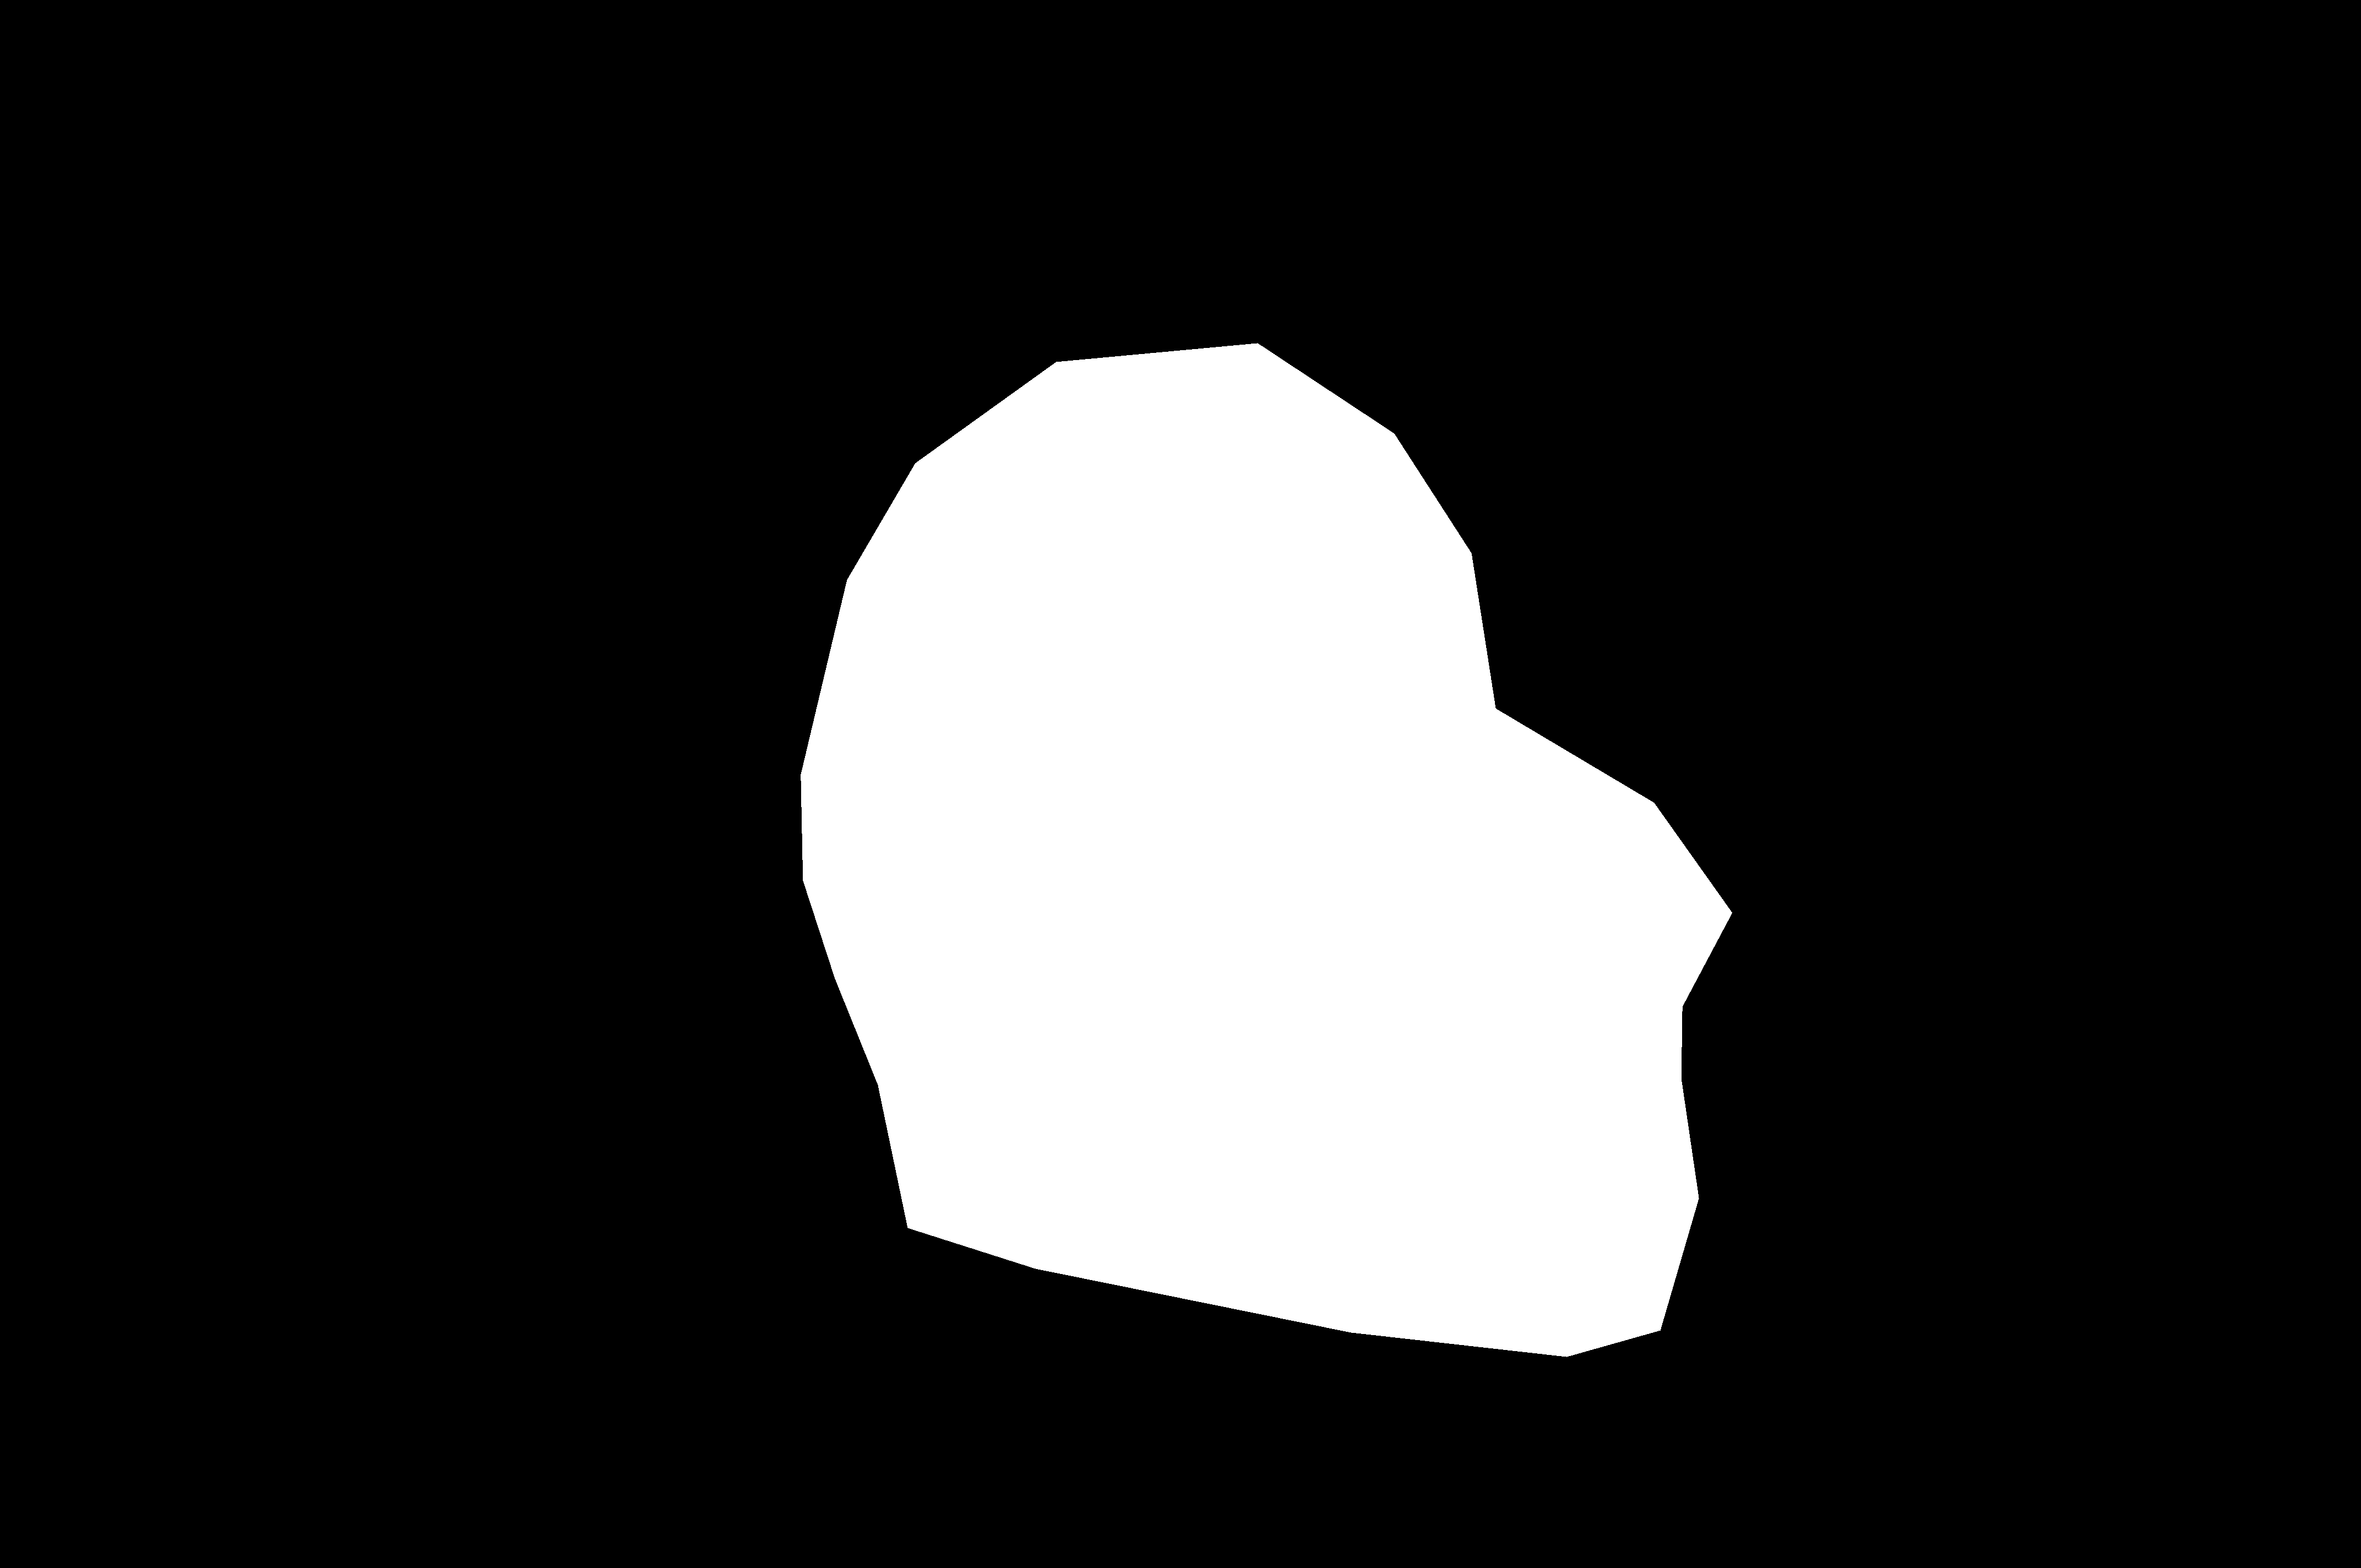

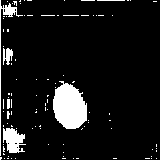

In [17]:
# Generate predictions for all images in the validation set

val_gen = MelanomaDetection(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.


## Future Scope

1. I plan on augmenting the training data (both lesions and masks ) using GAN's and then training the unet segmentation model and observing the results

2. Also, unsupervised approach such as clustering can be applied to such dataset for segmentation of images

3. Once the results are satisfactory, this model can be hosted on a webpage using Heroku, flask API's and docker where the webpage will predict if a person has melanoma or not based on the user's updated image

## REFERENCES

1. https://challenge2018.isic-archive.com/task1/
2. https://keras.io/examples/vision/oxford_pets_image_segmentation/
3. https://arxiv.org/abs/1907.00856
4. https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
5. https://www.cancer.org/cancer/melanoma-skin-cancer/about/what-is-melanoma.html

## LICENSING

Copyright <YEAR> <COPYRIGHT HOLDER>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

